<h1>DATA 620 - Web Analytics - Final Project<h1>
<h2>Team : Mohamed Thasleem, Kalikul Zaman and Jeyaraman Ramalingam<h2>
<h3>Introduction<h3>
<h6>Build an sentiment analysis from popular twitter account and analyze possible network analysis with multiple twitter accounts<h6>



Importing the libraries

In [129]:
#Import Libraries
import tweepy 
import pandas as pd
import sys
import csv
import matplotlib.pyplot as plt
import re
import twitter
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)


Declaring Functions required for this Project

In [130]:
def get_tweets(username): 
        auth = tweepy.OAuthHandler('uiFPpvK0s4ZQ0w0fjA6Nc2hHD', 'x1k4C3rsck0F3Iasi37j1vzn2RGu4ceM1VL0ylvVOIW1thDQwa') 
        auth.set_access_token('71980324-6VL5UR3GwTRWdrhZYMsuFCZCOQOWs1mrYA2eKh2R6', '8i7ssms0dZTqFyCsJRG1ASMMwJnLKUpLYniATeNwU0Ovl') 
        api = tweepy.API(auth) 
        tfile = []
        for tweet in tweepy.Cursor(api.user_timeline, screen_name = username).items():
            tfile.append([username, tweet.id_str,tweet.source, tweet.created_at,tweet.retweet_count,tweet.favorite_count, tweet.text])
        df=pd.DataFrame(tfile)
        return df    

def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white',max_words=3000,stopwords=STOPWORDS, mask=mask,contour_width=1, contour_color='navy' ).generate(words)
    plt.figure(figsize=(14,10),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(figsize=(16, 10))
    plt.bar(x_pos, counts,align='center',color='#ffd31d')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))
    
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    from nltk.corpus import stopwords
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words))
    

def clean_dataframe(df):
    #Data Preparation , cleanup the characters in tweet column
    pattern1 = re.compile(" ' # S % & ' ( ) * + , - . / : ; < = >  @ [ / ] ^ _ { | } ~")
    pattern2 = re.compile("@[A-Za-z0-9]+") 
    pattern3 = re.compile("https?://[A-Za-z0-9./]+")
    
    df_tweet = df['tweet']
    df_clean = []
    #Replace Symbols, UTF-8 Characters
    for item in df_tweet:
        tweet = re.sub(pattern1, "", str(item))   
        tweet = re.sub(pattern2, "", tweet)
        tweet = re.sub(pattern3, "", tweet)
        tweet=  str(tweet).replace(u"\\xe2\\x80\\x99","")
        tweet=  str(tweet).replace(u"\\xe2\\x80\\xa6","")
        tweet=  str(tweet).replace(u"\\xe2\\x80\\x9","")
        tweet=  str(tweet).replace(u"\\xf0","")
        tweet=  str(tweet).replace(u"\\x9f","")
        tweet=  str(tweet).replace(u"\\x91","")
        tweet=  str(tweet).replace(u"\\x87","")
        tweet=  str(tweet).replace(u"\\xbb","")
        tweet=  str(tweet).replace(u"\\xe2","")
        tweet=  str(tweet).replace(u"\\xe3","")
        tweet=  str(tweet).replace(u"\\x86","")
        tweet=  str(tweet).replace(u"\\x80","")
        tweet=  str(tweet).replace(u"\\xa6","")
        tweet=  str(tweet).replace(u"\\x8f","")
        tweet=  str(tweet).replace(u"\\xa4","")
        tweet=  str(tweet).replace(u"\\xe0","")
        tweet=  str(tweet).replace(u"b\'RT","")
        tweet=  str(tweet).replace(u"b\"RT","")
        tweet=  str(tweet).replace(u"\\xb8","")
        tweet=  str(tweet).replace(u"\\xa5","")
        tweet=  str(tweet).replace(u"\\xd7","")
        tweet=  str(tweet).replace(u"\\xd8","")
        df_clean.append(tweet)
    
    #Final Data Frame is ready
    df_mod = pd.DataFrame(df_clean,columns = ['tweet'])
    #Prepaer Clean Tweet and Calculate Length of Tweet
    df_mod['clean_tweet']=df_mod['tweet'].apply(lambda x: tweet_to_words(x))
    df_mod['Tweet_length']=df_mod['tweet'].apply(lambda x: clean_tweet_length(x))
    return df_mod

def predict_accuracy(person,df):
    #Calculating Sentiment
    sentiment = SentimentIntensityAnalyzer()
    def sentiment(tweet):
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1    
    df['VSA'] = np.array([ sentiment(tweet) for tweet in df['tweet'] ])

    df['sentiment']  = np.select(
        [
            df['VSA']==0, 
            df['VSA']>0,
            df['VSA']<0
        ], 
        [
            'Neutral', 
            'Negative',
            'Positive'
        ], 
        default='Unknown'
    )
    train,test = train_test_split(df,test_size=0.2,random_state=42)
    train_clean_tweet=[]
    for tweet in train['clean_tweet']:
        train_clean_tweet.append(tweet)
    test_clean_tweet=[]
    for tweet in test['clean_tweet']:
        test_clean_tweet.append(tweet)

    #Fit the Count Vectorizer on Training and Test data
    v = CountVectorizer(analyzer = "word")
    train_features= v.fit_transform(train_clean_tweet)
    test_features=v.transform(test_clean_tweet)

    #Create Classifiers for predicting the sentiment of tweet
    Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True,gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

#Fit the Classifier for the training data and predict the outcome of Trump tweet

    dense_features=train_features.toarray()
    dense_test= test_features.toarray()
    Accuracy=[]
    Model=[]
    accuracy_res=[]
    for classifier in Classifiers:
        try:
            fit = classifier.fit(train_features,train['sentiment'])
            pred = fit.predict(test_features)
        except Exception:
            fit = classifier.fit(dense_features,train['sentiment'])
            pred = fit.predict(dense_test)
        accuracy = accuracy_score(pred,test['sentiment'])
        Accuracy.append(accuracy)
        Model.append(classifier.__class__.__name__)
        accuracy_res.append([person,classifier.__class__.__name__,str(accuracy)])
    return accuracy_res    

def vader_sentiment(person,df_trump_mod):
    sentiment_res=[]
    sentiment = SentimentIntensityAnalyzer()
    def sentiment_analyzer_scores(text):
        score = sentiment.polarity_scores(text)
        lb = score['compound']
        if lb >= 0.05:
            return 1
        elif (lb > -0.05) and (lb < 0.05):
            return 0
        else:
            return -1
        
    df_trump_mod['VSA'] = np.array([ sentiment_analyzer_scores(tweet) for tweet in df_trump_mod['tweet'] ])
    
    pos_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] < 0]
    
    pos_pct=len(pos_tweets)*100/len(df_trump_mod['tweet'])
    neu_pct=len(neu_tweets)*100/len(df_trump_mod['tweet'])
    neg_pct=len(neg_tweets)*100/len(df_trump_mod['tweet'])
    sentiment_res.append([person,"Positive Percentage",str(pos_pct)])
    sentiment_res.append([person,"Negative Percentage",str(neg_pct)])
    sentiment_res.append([person,"Neutral Percentage",str(neu_pct)])
    return sentiment_res

def textblob_sentiment(person,df_trump_mod):
    sentiment_res=[]
    sentiment = SentimentIntensityAnalyzer()
    def sentiment(tweet):
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    df_trump_mod['VSA'] = np.array([ sentiment(tweet) for tweet in df_trump_mod['tweet'] ])
    df_trump_mod['sentiment']  = np.select(
        [
            df_trump_mod['VSA']==0, 
            df_trump_mod['VSA']>0,
            df_trump_mod['VSA']<0
        ], 
        [
            'Neutral', 
            'Negative',
            'Positive'
        ], 
        default='Unknown'
    )
    
    pos_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] < 0]
    
    pos_pct=len(pos_tweets)*100/len(df_trump_mod['tweet'])
    neu_pct=len(neu_tweets)*100/len(df_trump_mod['tweet'])
    neg_pct=len(neg_tweets)*100/len(df_trump_mod['tweet'])
    sentiment_res.append([person,"Positive Percentage",str(pos_pct)])
    sentiment_res.append([person,"Negative Percentage",str(neg_pct)])
    sentiment_res.append([person,"Neutral Percentage",str(neu_pct)])
    return sentiment_res


Loading the required files, API Calls are made but it is random and brings random data every time. Hence using the standard csv file obtained by API Call for this exercise

In [131]:
#Connect to twitter API and Obtain Donald Trump Tweets    
#df=get_tweets("@realDonaldTrump")  
#df_boris=get_tweets("@BorisJohnson")  
#df_modi=get_tweets("@narendramodi")  
#df_emmanuel=get_tweets("@EmmanuelMacron")  
#df_merkel=get_tweets("@Queen_Europe")  

df_trump=pd.read_csv("C:/Users/jey19/@realDonaldTrump_tweets_V1.csv")        
df_boris=pd.read_csv("C:/Users/jey19/@BorisJohnson_tweets_V1.csv")
df_macron=pd.read_csv("C:/Users/jey19/@EmmanuelMacron_tweets_V1.csv")
df_modi=pd.read_csv("C:/Users/jey19/@narendramodi_tweets_V1.csv")
df_merkel=pd.read_csv("C:/Users/jey19/@Queen_Europe_tweets_V1.csv")



Renaming Column Names and Calling Cleanup function to clean the data for any UTF-8 characters/symbols/unnecessary texts in the tweets

In [132]:
df_trump=df_trump.rename(columns={df_trump.columns[0]: "User Name", df_trump.columns[1]: "Tweet ID",df_trump.columns[2]: "Source",df_trump.columns[3]: "created_date",df_trump.columns[4]: "retweet_count",df_trump.columns[5]: "favourite_count",df_trump.columns[6]: "tweet"})
df_modi=df_modi.rename(columns={df_modi.columns[0]: "User Name", df_modi.columns[1]: "Tweet ID",df_modi.columns[2]: "Source",df_modi.columns[3]: "created_date",df_modi.columns[4]: "retweet_count",df_modi.columns[5]: "favourite_count",df_modi.columns[6]: "tweet"})
df_boris=df_boris.rename(columns={df_boris.columns[0]: "User Name", df_boris.columns[1]: "Tweet ID",df_boris.columns[2]: "Source",df_boris.columns[3]: "created_date",df_boris.columns[4]: "retweet_count",df_boris.columns[5]: "favourite_count",df_boris.columns[6]: "tweet"})
df_merkel=df_merkel.rename(columns={df_merkel.columns[0]: "User Name", df_merkel.columns[1]: "Tweet ID",df_merkel.columns[2]: "Source",df_merkel.columns[3]: "created_date",df_merkel.columns[4]: "retweet_count",df_merkel.columns[5]: "favourite_count",df_merkel.columns[6]: "tweet"})
df_macron=df_macron.rename(columns={df_macron.columns[0]: "User Name", df_macron.columns[1]: "Tweet ID",df_macron.columns[2]: "Source",df_macron.columns[3]: "created_date",df_macron.columns[4]: "retweet_count",df_macron.columns[5]: "favourite_count",df_macron.columns[6]: "tweet"})

df_trump_mod=clean_dataframe(df_trump)
df_macron_mod=clean_dataframe(df_macron)
df_merkel_mod=clean_dataframe(df_merkel)
df_boris_mod=clean_dataframe(df_boris)
df_modi_mod=clean_dataframe(df_modi)


Calling Predict Accuracy function to calculate Accuracy for the different classifiers used in the project.

C:\Users\jey19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 1.0, 'Accuracies of Models')

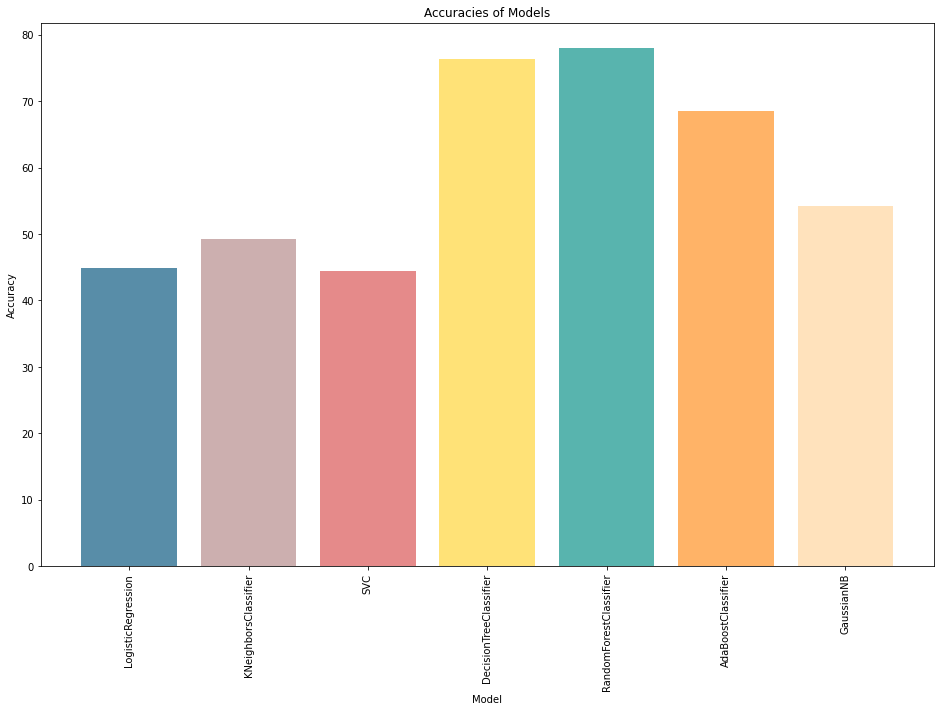

In [133]:
accuracy_trump = predict_accuracy("Donald Trump",df_trump_mod)
accuracy_trump = pd.DataFrame(accuracy_trump)
accuracy_trump=accuracy_trump.rename(columns={accuracy_trump.columns[0]: "Person", accuracy_trump.columns[1]: "Model",accuracy_trump.columns[2]: "Percentage"})
accuracy_trump=accuracy_trump.astype({'Percentage': 'float32'})
accuracy_trump['Percentage']=round(accuracy_trump['Percentage']*100,2) 
accuracy_trump
#Plot the Accuracy of Classifiers in predicting the sentiment of Trump Tweet
Index = accuracy_trump['Model']
Accuracy = accuracy_trump['Percentage']
plt.figure(figsize=(16, 10))
plt.bar(Index,Accuracy,color=['#588da8', '#ccafaf', '#e58a8a','#ffe277', '#58b4ae', '#ffb367', '#ffe2bc'])
plt.xticks(Index, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')


Frequently Used Words by Donald Trump in his masked image

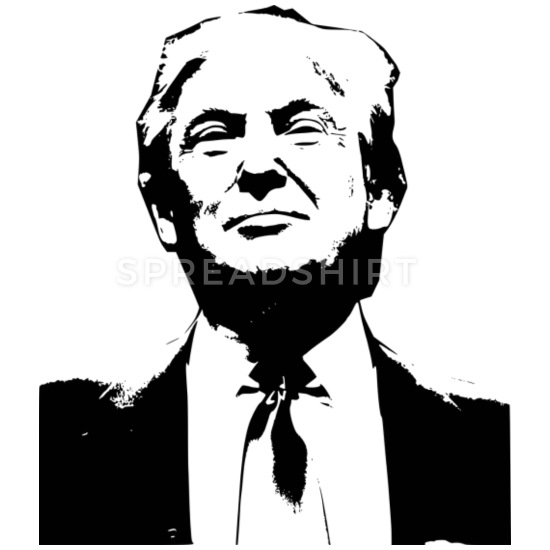

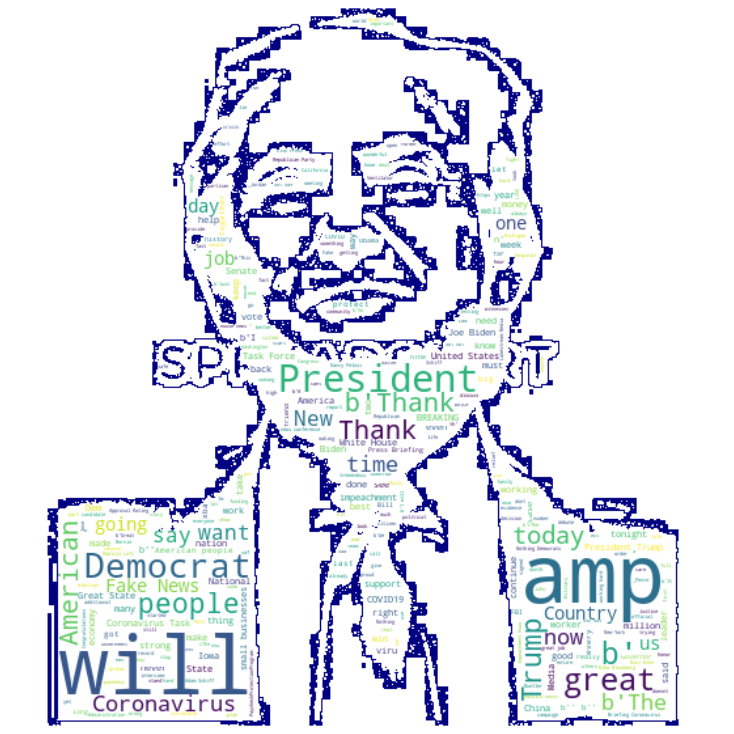

In [134]:
#WordCloud of Tweets

from PIL import Image
display(Image.open("C:/Users/jey19/Desktop/MSDS/Semester 2/DATA 620/Assignment/Week7/download.jpg")) 


mask= np.array(Image.open("C:/Users/jey19/Desktop/MSDS/Semester 2/DATA 620/Assignment/Week7/download.jpg"))
stopwords = set(STOPWORDS)
words = " ".join(review for review in df_trump_mod.tweet)
generate_wordcloud(str(words), mask)


Top 20 Words used by Donald Trump

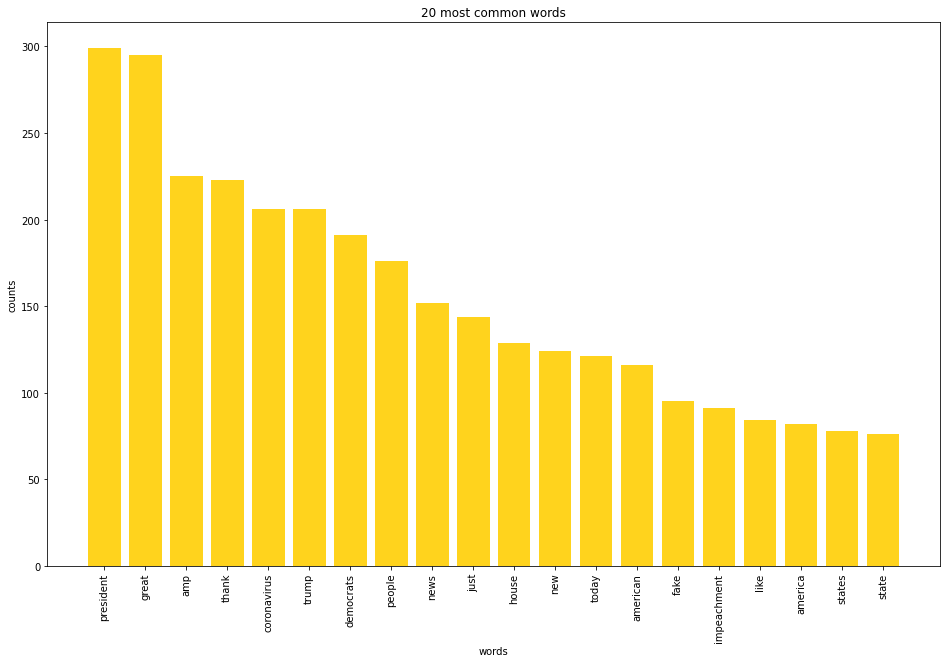

In [135]:
#Find Most common 20 words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df_trump_mod['tweet'])
plot_20_most_common_words(count_data, count_vectorizer)


Number of Favorite Tweets and Retweets

In [136]:
#Trend on Week Days with most number of tweets
fav_max = np.max(df_trump['favourite_count'])
rt_max  = np.max(df_trump['retweet_count'])
df_plt_fav = pd.DataFrame(zip(list(df_trump.favourite_count),list(df_trump.created_date)))
fav = df_trump[df_trump.favourite_count == fav_max].index[0]
rt  = df_trump[df_trump.retweet_count == rt_max].index[0]

print("The tweet with more likes is: \n{}".format(df_trump['tweet'][fav]))
print("Number of likes: {}".format(fav_max))

print("The tweet with more retweets is: \n{}".format(df_trump['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))


The tweet with more likes is: 
b'Kobe Bryant, despite being one of the truly great basketball players of all time, was just getting started in life.\xe2\x80\xa6 https://t.co/W9bvuDRMEY'
Number of likes: 725532
The tweet with more retweets is: 
b'RT @realDonaldTrump: https://t.co/JDS4zUXXJG'
Number of retweets: 128984


Plotting the tweet trends based on day of week

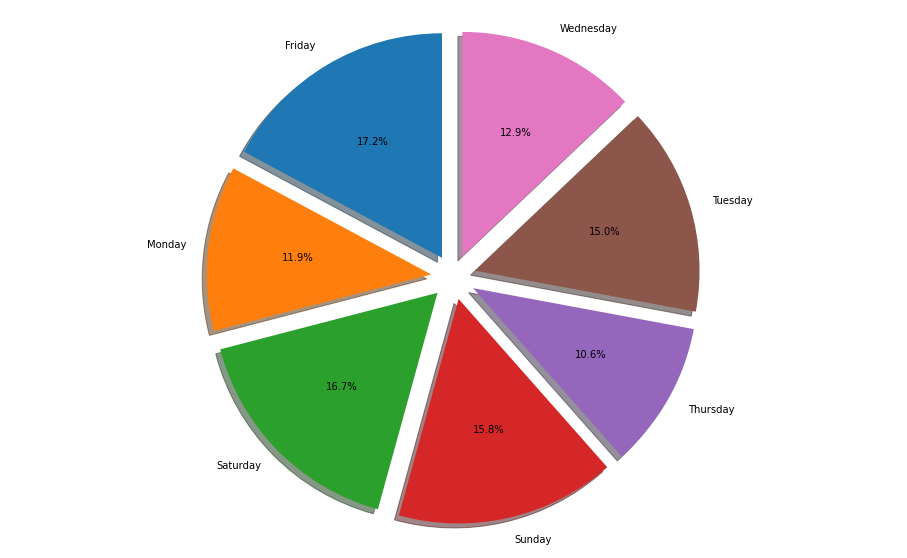

In [137]:
df_plt_fav=df_plt_fav.rename(columns={df_plt_fav.columns[0]: "Count", df_plt_fav.columns[1]: "Created_Date"})
df_plt_fav['Created_Date'] = pd.to_datetime(df_plt_fav['Created_Date'])
df_plt_fav['day_of_week']=df_plt_fav['Created_Date'].dt.day_name()
df_plt = df_plt_fav.groupby(["day_of_week"]).count()
Index=df_plt.index
Count=df_plt.Count
labels=df_plt.index
values=df_plt.Count
explode = [0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1]
plt.figure(figsize=(16, 10))
plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Sentiment Analysis by VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

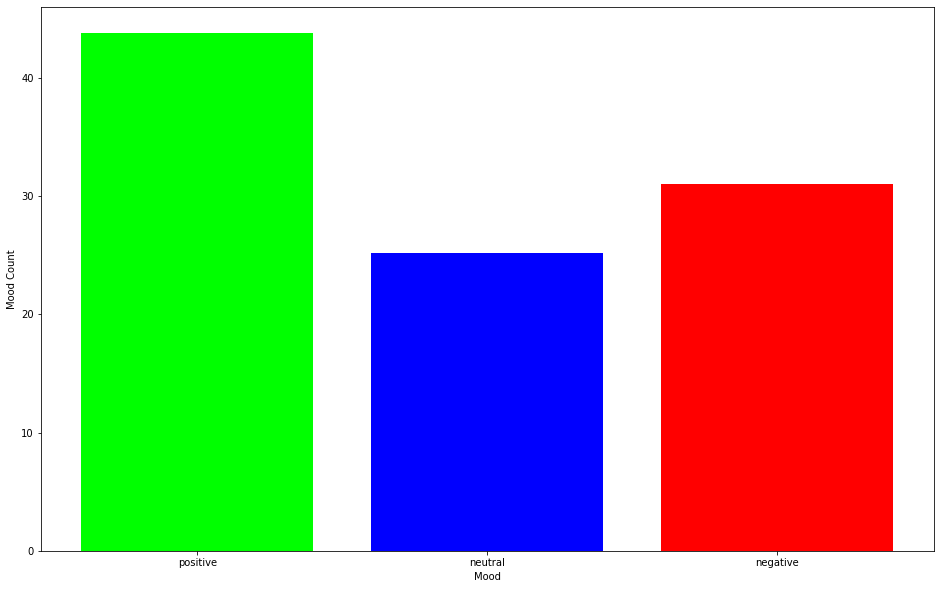

In [138]:
vader_res_trump = vader_sentiment("Donald Trump",df_trump_mod)
vader_res_boris = vader_sentiment("Boris Johnson",df_boris_mod)
vader_res_modi = vader_sentiment("Narendra Modi",df_modi_mod)
vader_res_merkel = vader_sentiment("Angela Merkel",df_merkel_mod)
vader_res_macron = vader_sentiment("Emmanuel Macron",df_macron_mod)
pos_pct=round(float(vader_res_trump[0][2]),2)
neu_pct=round(float(vader_res_trump[1][2]),2)
neg_pct=round(float(vader_res_trump[2][2]),2)
Index = [1,2,3]
tweet_pct = [pos_pct,neu_pct,neg_pct]
plt.figure(figsize=(16, 10))
plt.bar(Index,tweet_pct, color=['#00FF00', '#0000FF', '#FF0000'])
plt.xticks(Index,['positive','neutral','negative'])
plt.ylabel('Mood Count')
plt.xlabel('Mood')

vader_all_leaders=[]
for item in vader_res_boris:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_trump:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_macron:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_merkel:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_modi:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))

vader_all_df=pd.DataFrame(vader_all_leaders)    
vader_all_df
vader_all_df=vader_all_df.rename(columns={vader_all_df.columns[0]: "Leader", vader_all_df.columns[1]: "Mood",vader_all_df.columns[2]: "Percentage"})


Sentiment Analysis by TextBlob

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [139]:
tblob_res_trump = textblob_sentiment("Donald Trump",df_trump_mod)
tblob_res_macron = textblob_sentiment("Emmanuel Macron",df_macron_mod)
tblob_res_merkel = textblob_sentiment("Angela Merkel",df_merkel_mod)
tblob_res_modi = textblob_sentiment("Narendra Modi",df_modi_mod)
tblob_res_boris = textblob_sentiment("Boris Johnson",df_boris_mod)

Text(0.5, 0, 'Mood')

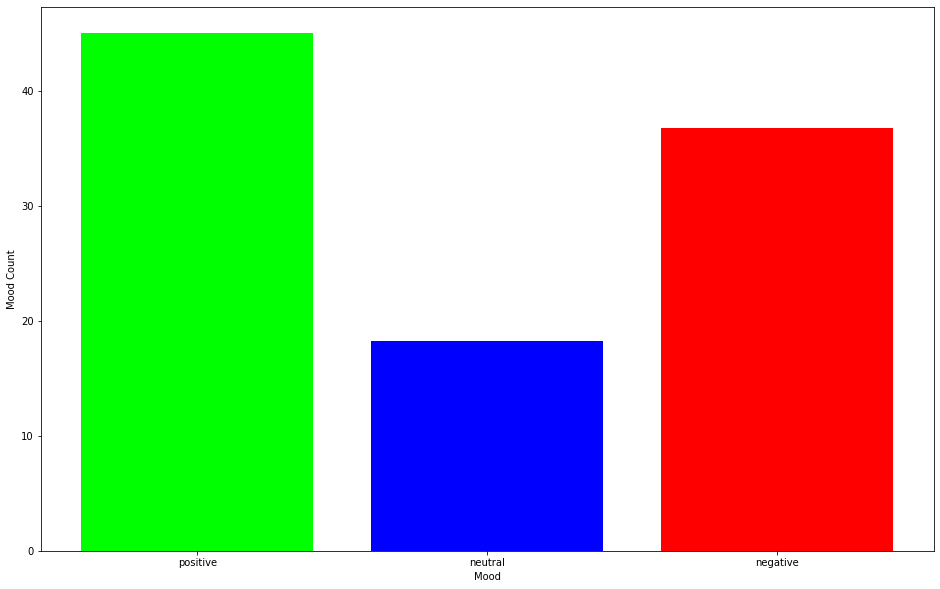

In [140]:
pos_pct=round(float(tblob_res_trump[0][2]),2)
neu_pct=round(float(tblob_res_trump[1][2]),2)
neg_pct=round(float(tblob_res_trump[2][2]),2)
Index = [1,2,3]
tweet_pct = [pos_pct,neu_pct,neg_pct]
plt.figure(figsize=(16, 10))
plt.bar(Index,tweet_pct, color=['#00FF00', '#0000FF', '#FF0000'])
plt.xticks(Index,['positive','neutral','negative'])
plt.ylabel('Mood Count')
plt.xlabel('Mood')


In [141]:
tblob_all_leaders=[]
for item in tblob_res_boris:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_trump:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_macron:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_merkel:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_modi:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))


tblob_all_df=pd.DataFrame(tblob_all_leaders)    


In [142]:
node=[]
p = re.compile("@[A-Za-z0-9_]+") 
for item in df_trump['tweet']:
    res=p.findall(str(item))
    node.append(p.findall(str(item)))
node
node_str=[]
for item in node:
    for x in item:
        node_str.append(x)
        
node_df = pd.DataFrame(node_str)
node_df
node_df['lower']=node_df[0].apply(lambda x: x.lower())
node_str=node_df.groupby('lower',sort=0)[0].first().tolist()
len(node_str)



745